In [ ]:
# ! pip install optuna

In [ ]:
# ! pip install shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
from sklearn.model_selection import train_test_split ,GridSearchCV ,learning_curve
from sklearn.preprocessing import LabelEncoder ,OrdinalEncoder

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import optuna
import shap
# print the JS visualization code to the notebook
shap.initjs()

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option("display.precision", 2)
plt.rcParams['axes.unicode_minus'] = False # 正常顯示負號

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# EDA

In [26]:
df = pd.read_csv('Student Placement.csv')
df # 707 rows × 13 columns

,DSA,DBMS,OS,CN,Mathmetics,Aptitute,Comm,Problem Solving,Creative,Hackathons,Skill 1,Skill 2,Profile
0,49,22,41,26,7,28,61,1,8,3,Javascript,Photoshop,UI/UX
1,39,46,45,47,3,35,65,4,10,4,HTML/CSS,GitHub,UI/UX
2,28,32,45,35,10,23,85,3,10,3,Photoshop,Figma,UI/UX
3,52,38,33,38,19,27,62,1,9,3,Photoshop,Figma,UI/UX
4,23,31,30,38,10,13,72,4,8,5,HTML/CSS,Figma,UI/UX
...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,17,32,18,11,7,40,60,2,6,1,Python,C/C++,Tech Support
703,7,22,25,33,8,29,71,3,5,0,Python,HTML/CSS,Tech Support
704,35,5,13,20,17,45,55,3,5,1,Python,Java,Tech Support
705,16,28,6,7,18,33,67,3,4,1,C/C++,HTML/CSS,Tech Support


In [27]:
df.info() # No missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DSA              707 non-null    int64 
 1   DBMS             707 non-null    int64 
 2   OS               707 non-null    int64 
 3   CN               707 non-null    int64 
 4   Mathmetics       707 non-null    int64 
 5   Aptitute         707 non-null    int64 
 6   Comm             707 non-null    int64 
 7   Problem Solving  707 non-null    int64 
 8   Creative         707 non-null    int64 
 9   Hackathons       707 non-null    int64 
 10  Skill 1          707 non-null    object
 11  Skill 2          707 non-null    object
 12  Profile          707 non-null    object
dtypes: int64(10), object(3)
memory usage: 71.9+ KB


In [28]:
# 列出類別欄位的唯一值
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"Unique values for column '{col}': {df[col].unique()}")

Unique values for column 'Skill 1': ['Javascript' 'HTML/CSS' 'Photoshop' 'GitHub' 'Figma' 'Node.js' 'Angular'
 'React' 'Python' 'R' 'Tensorflow' 'Deep Learning' 'Pytorch'
 'Machine Learning' 'C/C++' 'Java' 'MYSQL' 'Oracle' 'Linux' 'Ansible'
 'BASH/SHELL' 'Cisco Packet tracer' 'Wire Shark']
Unique values for column 'Skill 2': ['Photoshop' 'GitHub' 'Figma' 'HTML/CSS' 'Javascript' 'Node.js' 'React'
 'Angular' 'Pytorch' 'Tensorflow' 'Deep Learning' 'Python' 'R'
 'Machine Learning' 'MYSQL' 'Oracle' 'Linux' 'Java' 'C/C++' 'Wire Shark'
 'Cisco Packet tracer' 'BASH/SHELL' 'Ansible']
Unique values for column 'Profile': ['UI/UX' 'Web Developer' 'DATA Scientist' 'Software Engineer'
 'Database Administrator' 'Network Engineer' 'Tech Support']


In [29]:
# 數值欄位的統計資訊
df.describe()

,DSA,DBMS,OS,CN,Mathmetics,Aptitute,Comm,Problem Solving,Creative,Hackathons
count,707.00,707.00,707.00,707.00,707.00,707.00,707.00,707.00,707.00,707.00
mean,60.98,64.22,64.50,58.70,49.95,56.23,69.25,5.47,6.15,3.10
std,23.84,26.25,23.48,24.83,29.69,23.87,11.24,2.36,1.89,2.59
min,5.00,5.00,5.00,5.00,0.00,13.00,40.00,1.00,2.00,0.00
25%,45.00,41.00,53.00,38.50,22.50,35.00,62.00,4.00,5.00,1.00
50%,67.00,76.00,73.00,62.00,48.00,60.00,71.00,6.00,6.00,3.00
75%,80.00,85.00,82.50,80.00,78.00,77.00,78.00,7.00,7.00,5.00
max,99.00,100.00,95.00,100.00,99.00,99.00,90.00,10.00,10.00,10.00


In [30]:
# 類別欄位的統計資訊
df.describe(include=['object'])

,Skill 1,Skill 2,Profile
count,707,707,707
unique,23,23,7
top,HTML/CSS,HTML/CSS,UI/UX
freq,94,94,101


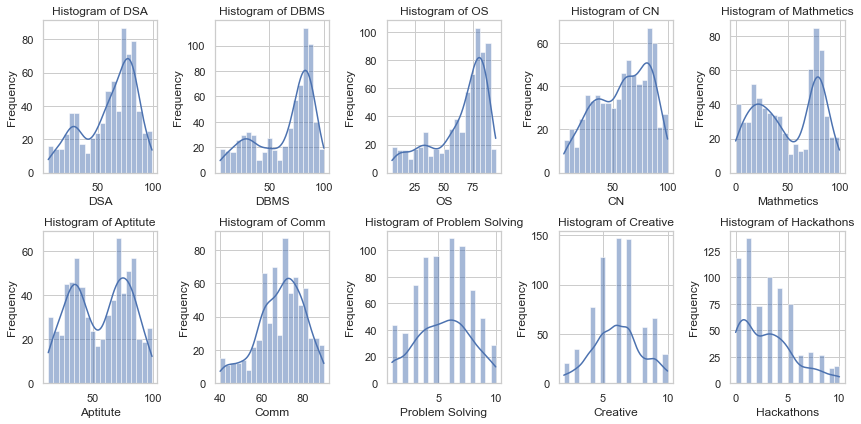

In [31]:
# 數值欄位做 histogram
numerical_columns = df.select_dtypes(include='number').columns

plt.figure(figsize=(12, 6))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, len(numerical_columns)//2, i)
    sns.histplot(df[column], bins=20, kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

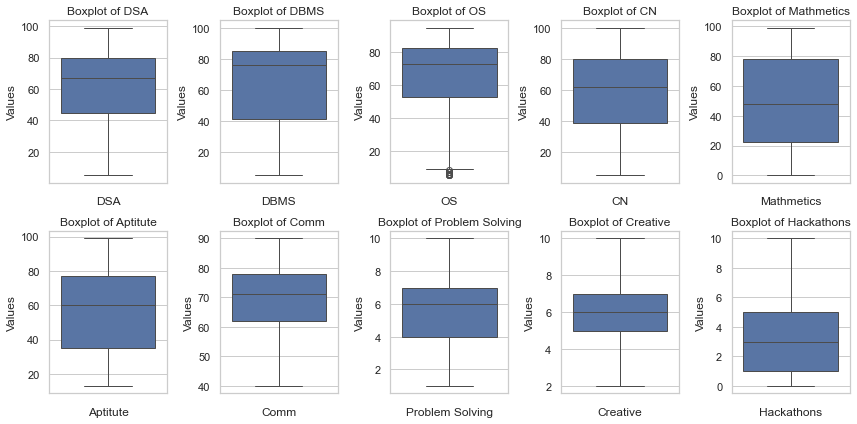

In [32]:
# 數值欄位做 boxplot
numerical_columns = df.select_dtypes(include='number').columns

plt.figure(figsize=(12, 6))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, len(numerical_columns)//2, i)
    sns.boxplot(data=df[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Values')
plt.tight_layout()
plt.show()

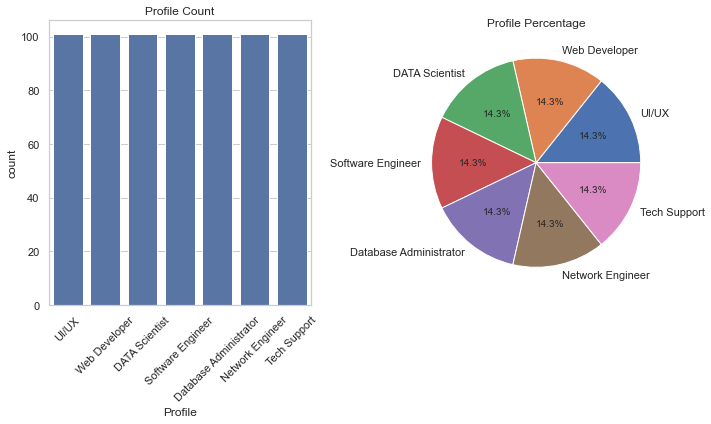

Profile
UI/UX                     101
Web Developer             101
DATA Scientist            101
Software Engineer         101
Database Administrator    101
Network Engineer          101
Tech Support              101
Name: count, dtype: int64


In [33]:
# Profile 的分佈
plt.figure(figsize=(10, 6))
plt.subplot(1 ,2 ,1)
sns.countplot(data =df ,x ='Profile')
plt.xticks(rotation=45)
plt.title('Profile Count')

plt.subplot(1 ,2 ,2)
profile_counts = df['Profile'].value_counts()
plt.pie(profile_counts, labels = profile_counts.index, autopct='%1.1f%%')
plt.title('Profile Percentage')
plt.tight_layout()
plt.show()

print(df['Profile'].value_counts()) # 各Profile的個數都為101，百分比也相同

# Feature Engineering

In [34]:
use_columns = ['Profile']
df_copy = df.copy()
label_encoder = LabelEncoder()
for col in use_columns:
    df_copy[col + '_encoded'] = label_encoder.fit_transform(df[col])
    original_values = df_copy[col].unique()
    encoded_values = df_copy[col + '_encoded'].unique()
    print(f"Original values for column '{col}': {original_values}")
    print(f"Encoded values for column '{col}': {encoded_values}")
    print()

Original values for column 'Profile': ['UI/UX' 'Web Developer' 'DATA Scientist' 'Software Engineer'
 'Database Administrator' 'Network Engineer' 'Tech Support']
Encoded values for column 'Profile': [5 6 0 3 1 2 4]



In [35]:
# Feature Encoding

# Label Encoding 將 Label 轉換為數字編碼
lb_encoder = LabelEncoder()
df['Profile'] = lb_encoder.fit_transform(df['Profile'])
# ['UI/UX' 'Web Developer' 'DATA Scientist' 'Software Engineer' 'Database Administrator' 'Network Engineer' 'Tech Support']
# [5 6 0 3 1 2 4]

# Ordinal Encoding 將類別變數轉換為有序編碼
or_encoder = OrdinalEncoder()
use_columns = ['Skill 1', 'Skill 2']
df[use_columns] = or_encoder.fit_transform(df[use_columns])
df.head()

,DSA,DBMS,OS,CN,Mathmetics,Aptitute,Comm,Problem Solving,Creative,Hackathons,Skill 1,Skill 2,Profile
0,49,22,41,26,7,28,61,1,8,3,10.0,16.0,5
1,39,46,45,47,3,35,65,4,10,4,8.0,7.0,5
2,28,32,45,35,10,23,85,3,10,3,16.0,6.0,5
3,52,38,33,38,19,27,62,1,9,3,16.0,6.0,5
4,23,31,30,38,10,13,72,4,8,5,8.0,6.0,5


# Hetmap

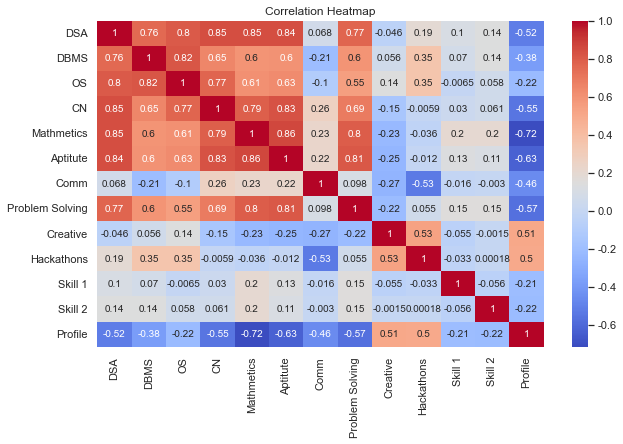

In [ ]:
# 熱力圖
corr = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# 相關性絕對值
correlation_matrix = df.corr().abs()
top_correlations = correlation_matrix['Profile'].sort_values(ascending=False).head(10)
print(top_correlations)

Profile            1.00
Mathmetics         0.72
Aptitute           0.63
Problem Solving    0.57
CN                 0.55
DSA                0.52
Creative           0.51
Hackathons         0.50
Comm               0.46
DBMS               0.38
Name: Profile, dtype: float64


# Train Test Split

In [ ]:
# 資料分割
X = df[['Mathmetics' ,'Aptitute' ,'Problem Solving' ,'CN' ,'Creative']] # 特徵欄位
y = df['Profile'] # 標籤欄位

X_train ,X_test ,y_train ,y_test = train_test_split(X ,y ,test_size=0.5 ,random_state=42 ,stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts(normalize=True))
print('='*40)
print(pd.Series(y_test).value_counts())
print(pd.Series(y_test).value_counts(normalize=True))

(353, 5) (354, 5) (353,) (354,)
Profile
1    51
5    51
0    51
6    50
2    50
3    50
4    50
Name: count, dtype: int64
Profile
1    0.14
5    0.14
0    0.14
6    0.14
2    0.14
3    0.14
4    0.14
Name: proportion, dtype: float64
Profile
3    51
4    51
6    51
2    51
0    50
5    50
1    50
Name: count, dtype: int64
Profile
3    0.14
4    0.14
6    0.14
2    0.14
0    0.14
5    0.14
1    0.14
Name: proportion, dtype: float64


# Model
使用不同的model來訓練，GridSearchCV來找尋參數、產生評估指標、繪製學習曲線、儲存模型、解釋模型

In [44]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        51
           6       1.00      1.00      1.00        50

    accuracy                           1.00       353
   macro avg       1.00      1.00      1.00       353
weighted avg       1.00      1.00      1.00       353

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       0.96      1.00      0.98        51
           3       1.00      0.96      0.98        51
           4       1.00      1.00      1.00        51
           5       0.94      0.94      0.94        50
   

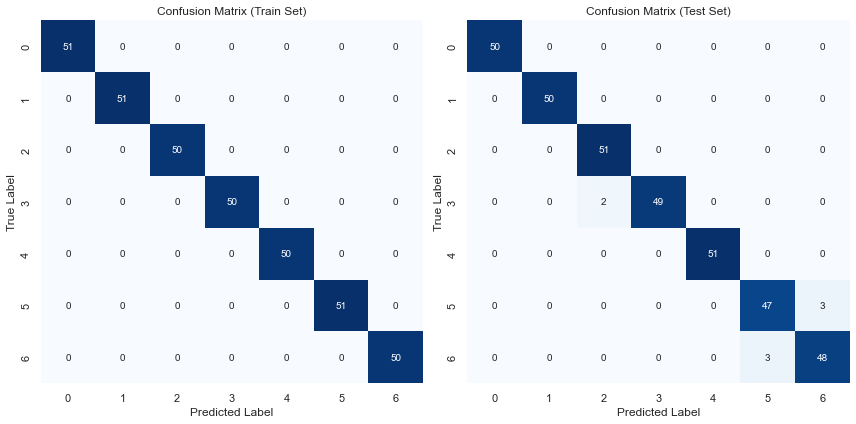

In [46]:
# Classification分類問題用
from sklearn.metrics import roc_auc_score ,roc_curve ,classification_report ,confusion_matrix

# Evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print("Train Set:")
    print(classification_report(y_train, y_train_pred))
    print("Test Set:")
    print(classification_report(y_test, y_test_pred))

    # 計算 AUC（適用於多分類）
    train_auc = roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovr')
    test_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')

    # 計算 AUC（二元分類）
    # train_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    # test_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    print(f"Train AUC: {train_auc:.6f}")
    print(f"Test AUC: {test_auc:.6f}")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title('Confusion Matrix (Train Set)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title('Confusion Matrix (Test Set)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

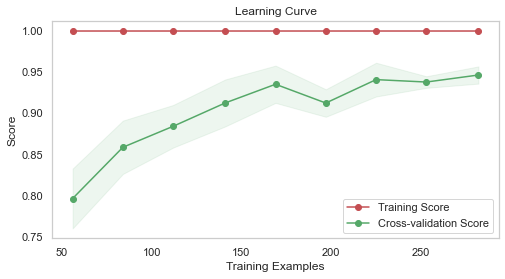

Train Sizes: [ 28  56  84 112 141 169 197 225 253 282]
Train Scores Mean: [nan  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Test Scores Mean: [       nan 0.79609658 0.85839034 0.88390342 0.91227364 0.93496982
 0.91215292 0.94060362 0.937666   0.94619718]


In [48]:
from sklearn.model_selection import learning_curve

# Learning Curve
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, n_jobs=-1)
    # Calculate the mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 4))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")
    plt.legend(loc="best")
    plt.show()

    # Print additional information
    print("Train Sizes:", train_sizes)
    print("Train Scores Mean:", train_scores_mean)
    print("Test Scores Mean:", test_scores_mean)
plot_learning_curve(xgb_model, X_train, y_train)


===== 訓練 RandomForest 模型 =====
Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        51
           6       1.00      1.00      1.00        50

    accuracy                           1.00       353
   macro avg       1.00      1.00      1.00       353
weighted avg       1.00      1.00      1.00       353

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       0.96      1.00      0.98        51
           3       1.00      0.96      0.98        51
           4       1.00      1.00      1.00        51
           5       0.96  

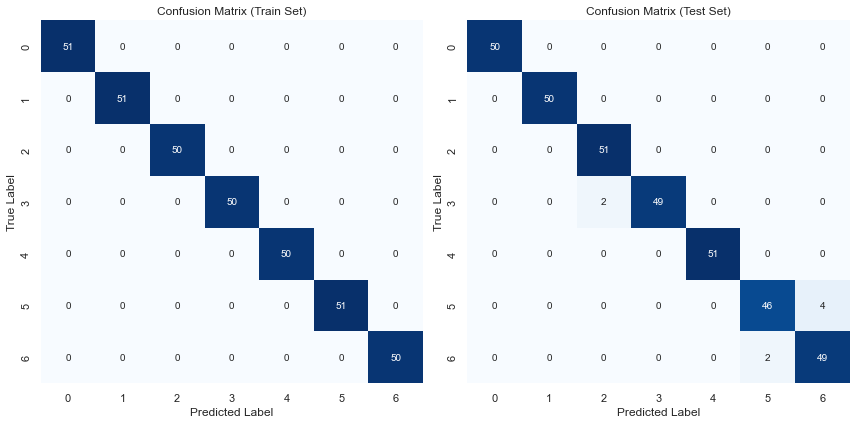


===== 訓練 KNN 模型 =====
Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        51
           2       0.92      0.96      0.94        50
           3       0.96      0.92      0.94        50
           4       0.92      0.94      0.93        50
           5       0.95      0.82      0.88        51
           6       0.89      1.00      0.94        50

    accuracy                           0.95       353
   macro avg       0.95      0.95      0.95       353
weighted avg       0.95      0.95      0.95       353

Test Set:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        50
           1       0.98      0.98      0.98        50
           2       0.92      0.88      0.90        51
           3       0.87      0.92      0.90        51
           4       0.87      0.88      0.87        51
           5       0.88      0.70 

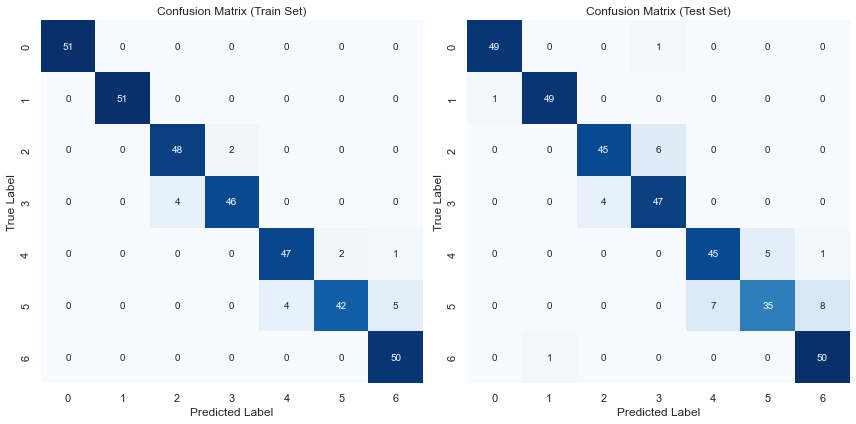


===== 訓練 LightGBM 模型 =====
Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        51
           6       1.00      1.00      1.00        50

    accuracy                           1.00       353
   macro avg       1.00      1.00      1.00       353
weighted avg       1.00      1.00      1.00       353

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.96      1.00      0.98        50
           2       0.98      0.88      0.93        51
           3       0.93      0.98      0.95        51
           4       1.00      1.00      1.00        51
           5       1.00      

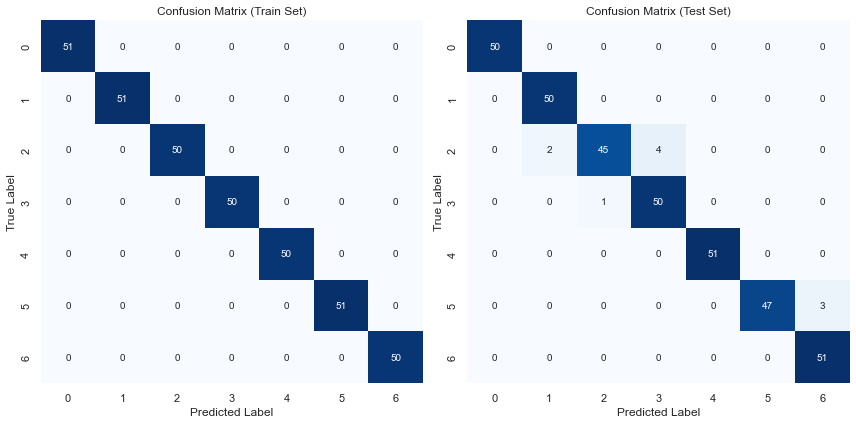


===== 訓練 CatBoost 模型 =====
Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        51
           6       1.00      1.00      1.00        50

    accuracy                           1.00       353
   macro avg       1.00      1.00      1.00       353
weighted avg       1.00      1.00      1.00       353

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       0.96      0.96      0.96        51
           3       0.96      0.96      0.96        51
           4       1.00      1.00      1.00        51
           5       0.96      

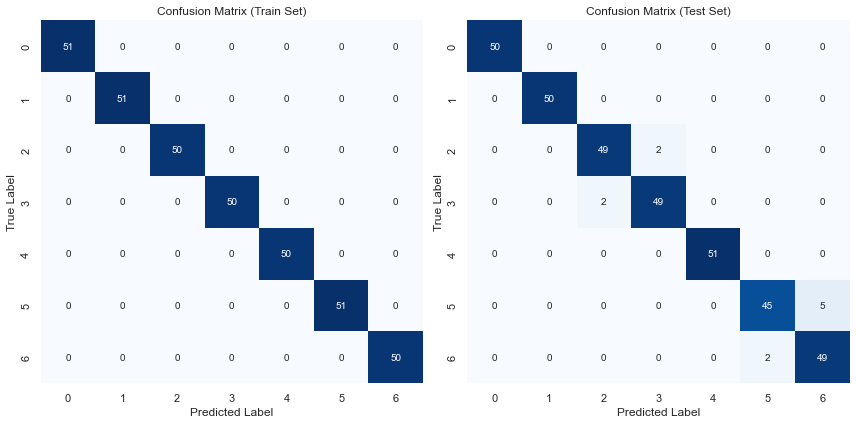


===== 訓練 LogisticRegression 模型 =====
Train Set:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        51
           1       0.76      0.73      0.74        51
           2       0.76      0.84      0.80        50
           3       0.88      0.90      0.89        50
           4       0.90      0.70      0.79        50
           5       0.86      0.84      0.85        51
           6       0.77      0.88      0.82        50

    accuracy                           0.84       353
   macro avg       0.84      0.84      0.84       353
weighted avg       0.84      0.84      0.84       353

Test Set:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        50
           1       0.74      0.50      0.60        50
           2       0.70      0.86      0.77        51
           3       0.81      0.90      0.85        51
           4       0.94      0.61      0.74        51
           5       

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


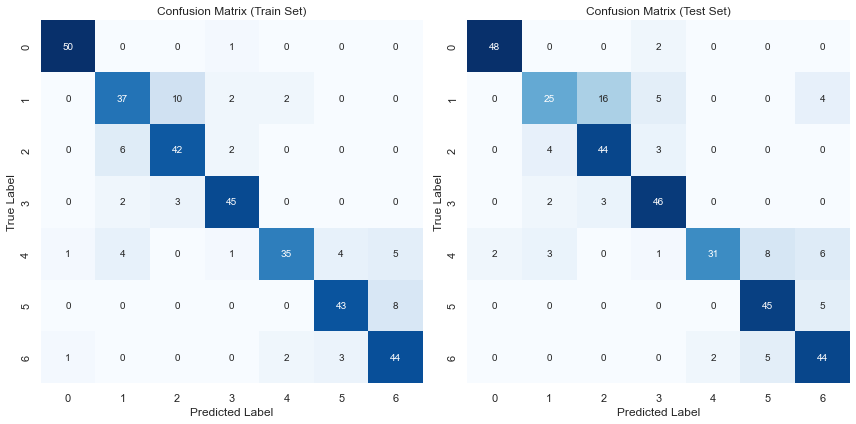


===== 訓練 SVM 模型 =====
Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        51
           2       0.98      0.88      0.93        50
           3       0.89      0.98      0.93        50
           4       0.82      0.80      0.81        50
           5       0.74      0.69      0.71        51
           6       0.85      0.94      0.90        50

    accuracy                           0.90       353
   macro avg       0.90      0.90      0.90       353
weighted avg       0.90      0.90      0.90       353

Test Set:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       0.98      0.98      0.98        50
           2       0.96      0.94      0.95        51
           3       0.94      0.96      0.95        51
           4       0.83      0.75      0.78        51
           5       0.67      0.74 

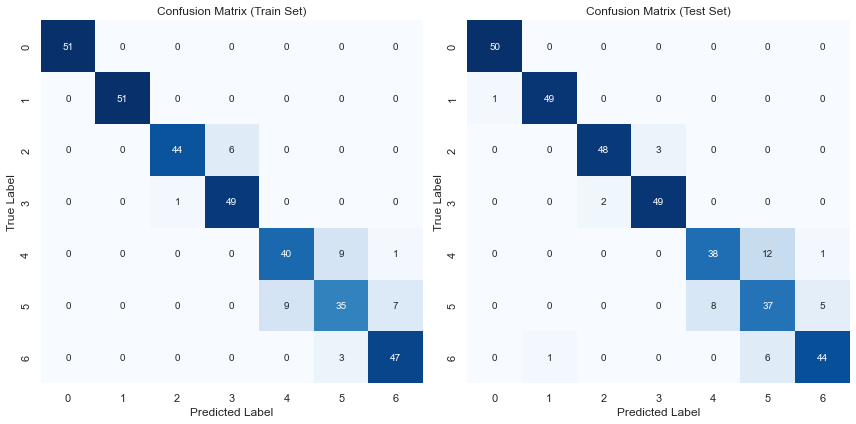


===== 訓練 GradientBoosting 模型 =====
Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        51
           6       1.00      1.00      1.00        50

    accuracy                           1.00       353
   macro avg       1.00      1.00      1.00       353
weighted avg       1.00      1.00      1.00       353

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       0.98      0.98      0.98        51
           3       0.98      0.98      0.98        51
           4       1.00      1.00      1.00        51
           5       0.

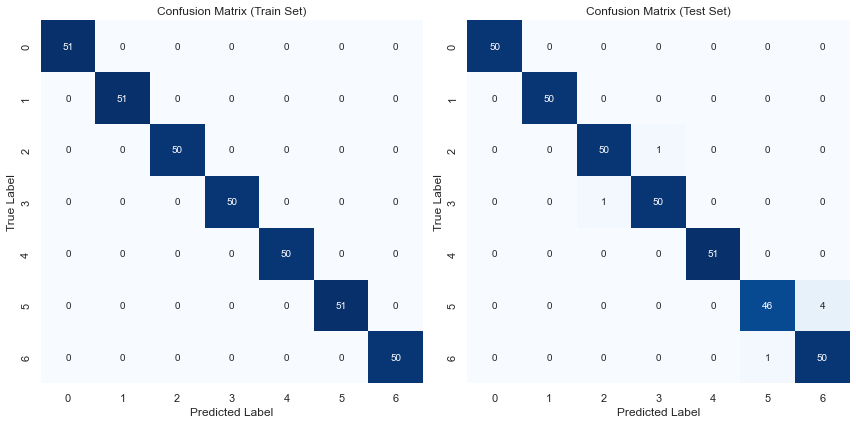

In [47]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgb
from catboost import CatBoostClassifier

models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
    "LogisticRegression": LogisticRegression(),
    "SVM": SVC(probability=True),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

for name, model in models.items():
    print(f"\n===== 訓練 {name} 模型 =====")
    model.fit(X_train, y_train)
    evaluate_model(model, X_train, y_train, X_test, y_test)

# XGBClassifier

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score:  0.9745271629778672
Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        51
           2       0.98      1.00      0.99        50
           3       1.00      0.98      0.99        50
           4       1.00      1.00      1.00        50
           5       1.00      0.96      0.98        51
           6       0.96      1.00      0.98        50

    accuracy                           0.99       353
   macro avg       0.99      0.99      0.99       353
weighted avg       0.99      0.99      0.99       353

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1

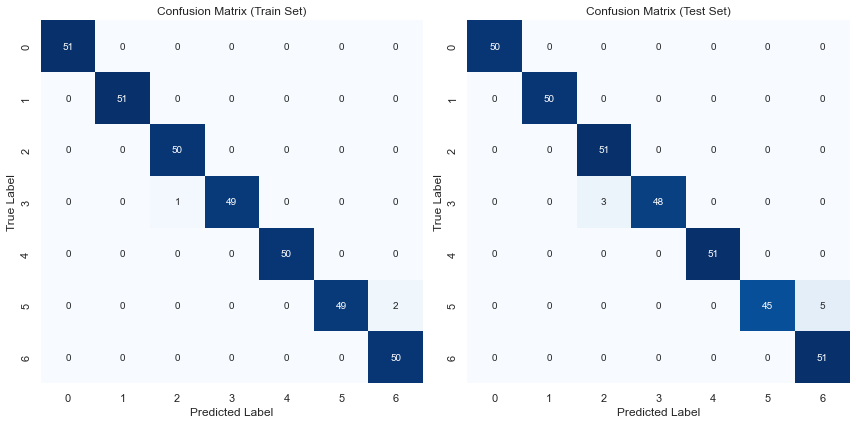

In [ ]:
xgb_parnams = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_parnams, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
xgb_grid_search.fit(X_train, y_train)
print("Best parameters found: ", xgb_grid_search.best_params_)
print("Best cross-validation score: ", xgb_grid_search.best_score_)

Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        51
           2       0.98      1.00      0.99        50
           3       1.00      0.98      0.99        50
           4       1.00      1.00      1.00        50
           5       1.00      0.96      0.98        51
           6       0.96      1.00      0.98        50

    accuracy                           0.99       353
   macro avg       0.99      0.99      0.99       353
weighted avg       0.99      0.99      0.99       353

Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       0.94      1.00      0.97        51
           3       1.00      0.94      0.97        51
           4       1.00      1.00      1.00        51
           5       1.00      0.90      0.95        50
   

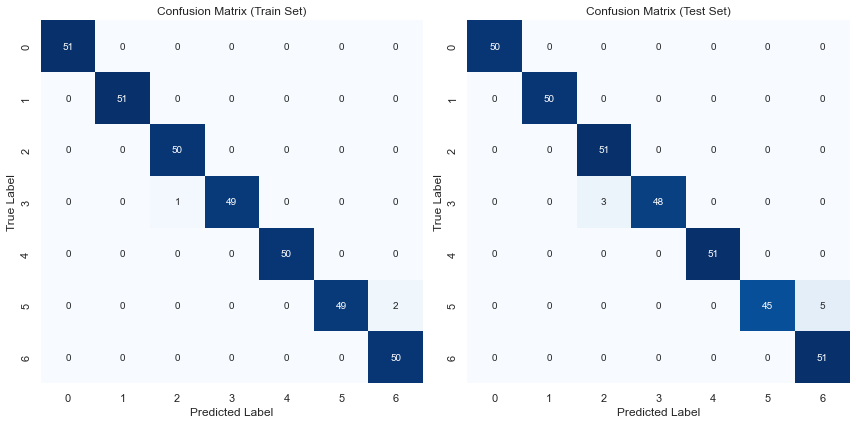

In [50]:
best_xgb_model = xgb_grid_search.best_estimator_
evaluate_model(best_xgb_model, X_train, y_train, X_test, y_test)

# Save Model

In [51]:
from joblib import dump, load

# 儲存模型
dump(best_xgb_model ,'best_xgboost_model.joblib')

['best_xgboost_model.joblib']

# Shap

In [ ]:
import shap

# 建立 SHAP Explainer（針對樹模型使用 TreeExplainer）
explainer = shap.TreeExplainer(best_xgb_model)

# 計算 SHAP 值
shap_values = explainer(X_train)

print("X_train shape:", X_train.shape)
print("SHAP values shape:", shap_values.shape) # (x, y, z)，x: 樣本數, y: 特徵數量, z: Label的數量

X_train shape: (353, 5)
SHAP values shape: (353, 5, 7)


Summary plot for class 0


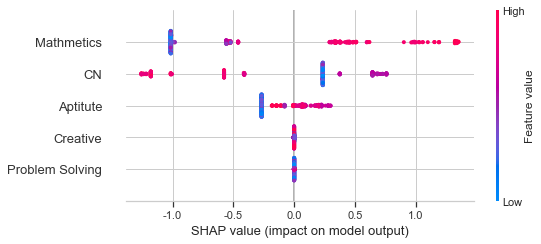

Summary plot for class 1


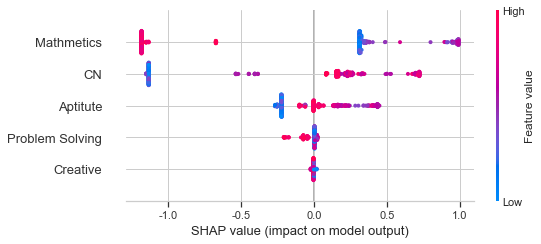

Summary plot for class 2


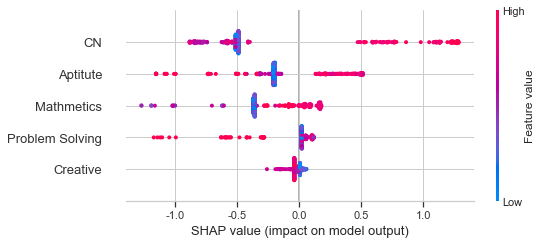

Summary plot for class 3


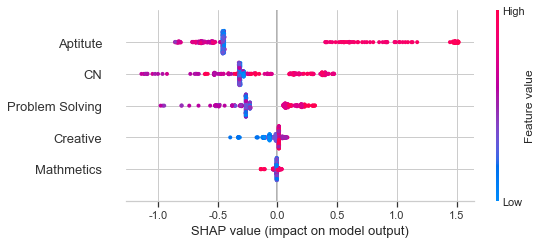

Summary plot for class 4


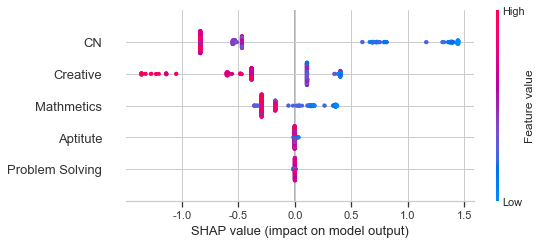

Summary plot for class 5


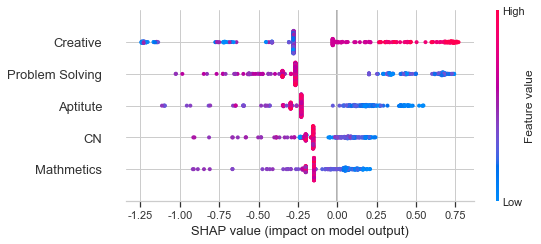

Summary plot for class 6


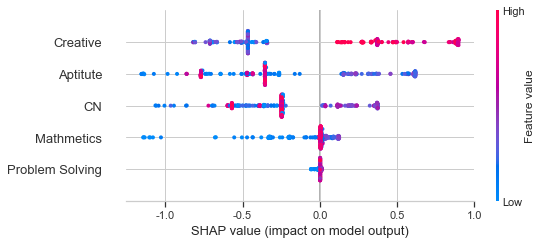

In [54]:
# 產生各標籤的 SHAP Summary Plot
for class_index in range(shap_values.shape[2]):
    print("Summary plot for class", class_index)
    shap.summary_plot(shap_values[:, :, class_index], X_train)

Summary plot for class 0


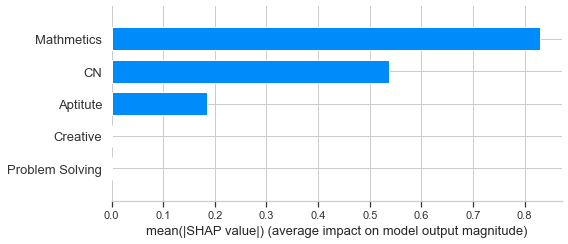

Summary plot for class 1


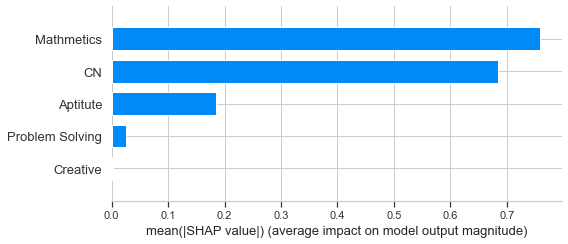

Summary plot for class 2


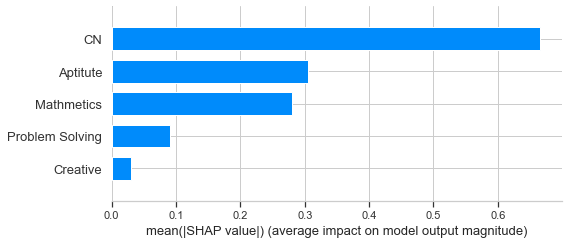

Summary plot for class 3


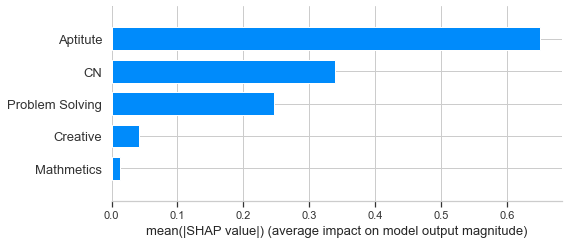

Summary plot for class 4


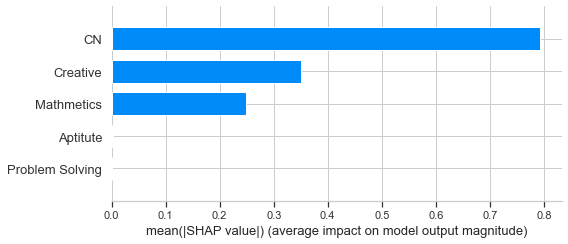

Summary plot for class 5


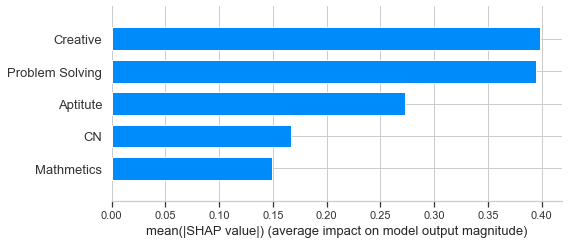

Summary plot for class 6


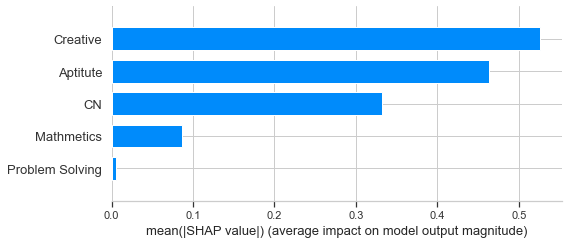

In [56]:
# 產生各標籤的 Bar chart of mean importance
for class_index in range(shap_values.shape[2]):
    print("Summary plot for class", class_index)
    shap.summary_plot(shap_values[:, :, class_index] ,X_train ,plot_type="bar")

Summary plot for class 0


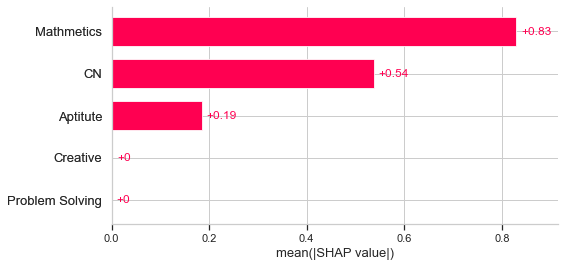

Summary plot for class 1


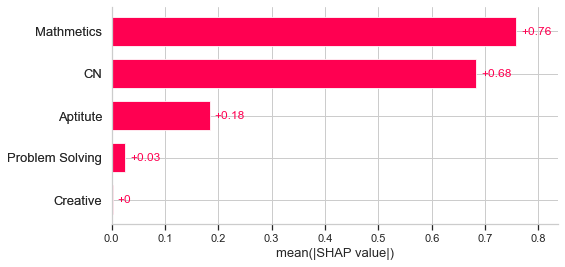

Summary plot for class 2


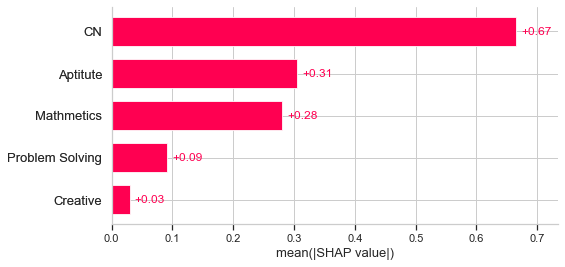

Summary plot for class 3


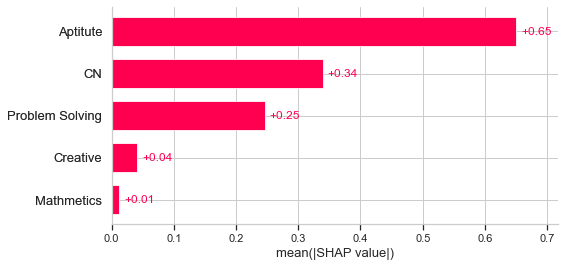

Summary plot for class 4


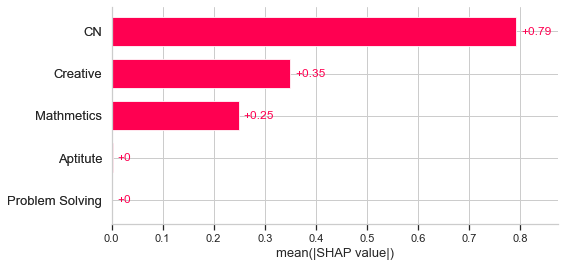

Summary plot for class 5


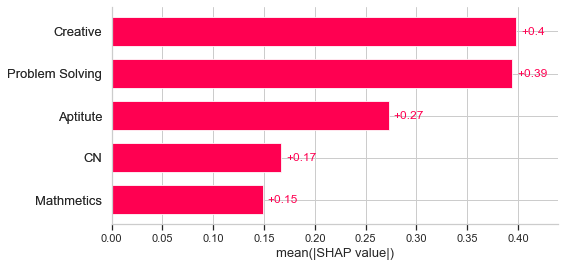

Summary plot for class 6


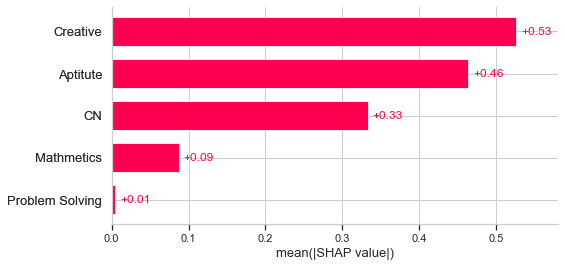

In [57]:
# 產生各標籤的 Global bar plot
for class_index in range(shap_values.shape[2]):
    print("Summary plot for class", class_index)
    # shap.summary_plot(shap_values[:, :, class_index] ,X ,plot_type="bar")
    shap.plots.bar(shap_values[:, :, class_index])

Class 0 :DATA Scientist
*   Mathmetics :+0.83
*   CN :+0.54
*   Aptitute :+0.19

Class 1 :Database Administrator
*   Mathmetics :+0.76
*   CN :+0.68
*   Aptitute :+0.18

Class 2 :Network Engineer
*   CN :+0.67
*   Aptitute :+0.31
*   Mathmetics :+0.28

Class 3 :Software Engineer
*   Aptitute :+0.65
*   CN :+0.34
*   Problem Solving :+0.25

Class 4 :Tech Support
*   CN :+0.79
*   Creative :+0.35
*   Mathmetics :+0.25

Class 5 :UI/UX
*   Creative :+0.4
*   Problem Solving :+0.39
*   Aptitute :+0.27

Class 6 :Web Developer
*   Creative :+0.53
*   Aptitute :+0.46
*   CN :+0.33

# Reference
https://www.kaggle.com/datasets/yuvjeetarora/student-job-profile/data

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html

https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html